In [ ]:
pip install -q kaggle


In [ ]:
%%bash
kaggle datasets download -d lantian773030/pokemonclassification
unzip -qq pokemonclassification.zip


In [ ]:
print(12)

12


In [ ]:
import torch

In [ ]:
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from PIL import Image
from tqdm.notebook import tqdm

class PokemonDataset(Dataset):
    SPLIT_RANDOM_SEED = 42
    TEST_SIZE = 0.25

    def __init__(self, root, train=True, load_to_ram=True, transform=None):
        super().__init__()
        self.root = root
        self.train = train
        self.load_to_ram = load_to_ram
        self.transform = transform
        self.classes = sorted(os.listdir(self.root))
        self.all_files = []
        self.all_labels = []
        self.images = []
        for i, class_name in tqdm(enumerate(self.classes), total = len(self.classes)):
            files = sorted(os.listdir(os.path.join(self.root, class_name)))
            train_files, test_files = train_test_split(files, random_state=self.SPLIT_RANDOM_SEED + i, test_size = self.TEST_SIZE)

            if train:
                self.all_files += train_files
                self.all_labels += [i] * len(train_files)
                if self.load_to_ram:
                    self.images += self._load_images(train_files, i)
            else:
                self.all_files += test_files
                self.all_labels += [i] * len(test_files)
                if self.load_to_ram:
                    self.images += self._load_images(test_files, i)

    def _load_images(self, image_files, label):
        images = []
        for filename in image_files:
            image = Image.open(os.path.join(self.root, self.classes[label], filename))
            images += [image]

        return images

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, item):
        label = self.all_labels[item]
        if self.load_to_ram:
            image = self.images[item]
        else:
            filename = self.all_files[item]
            image = Image.open(os.path.join(self.root, self.classes[label], filename)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, label


In [ ]:
import glob
bad_images = glob.glob('PokemonData/*/*.svg')

In [ ]:
for bad_image in bad_images:
    os.remove(bad_image)

In [ ]:
train_dataset = PokemonDataset(root = 'PokemonData', train= True, load_to_ram = False)

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
train_dataset.classes[label]

'Alolan Sandslash'

In [ ]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize,
])

test_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    normalize,
])


In [ ]:
train_dataset = PokemonDataset(root = 'PokemonData', train= True, load_to_ram = False, transform=test_transform)
test_dataset = PokemonDataset(root = 'PokemonData', train= False, load_to_ram = False, transform=test_transform)


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size = 16,  pin_memory= True, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size = 16,  pin_memory= True, shuffle=True, num_workers=4)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})

def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))

    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()


In [ ]:
def train():
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_accuracy = 0.0, 0.0
        model.train()

        for images, labels in tqdm(train_loader, desc=f'training enoch number {epoch}'):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.shape[0]
            train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        if scheduler is not None:
            scheduler.step()

        train_loss /= len(train_loader.dataset)
        train_accuracy /= len(train_loader.dataset)
        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_loss, test_accuracy = 0.0, 0.0
        model.eval()

        for images, labels in tqdm(test_loader, desc='Validating'):
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                logits = model(images)
                loss = criterion(logits, labels)

            test_loss += loss.item() * images.shape[0]
            test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        test_loss /= len(test_loader.dataset)
        test_accuracy /= len(test_loader.dataset)
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]

        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce GTX 1060 3GB


In [ ]:
import torch
print("CUDA доступна:", torch.cuda.is_available())
print("Количество GPU:", torch.cuda.device_count())
print("Имя GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")


CUDA доступна: True
Количество GPU: 1
Имя GPU: NVIDIA GeForce GTX 1060 3GB


In [ ]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
NUM_EPOCHS = 10
model = mobilenet_v2(num_classes=len(train_dataset.classes)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NUM_EPOCHS)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
sum(d.numel() for d in model.parameters())

2416022

In [ ]:
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

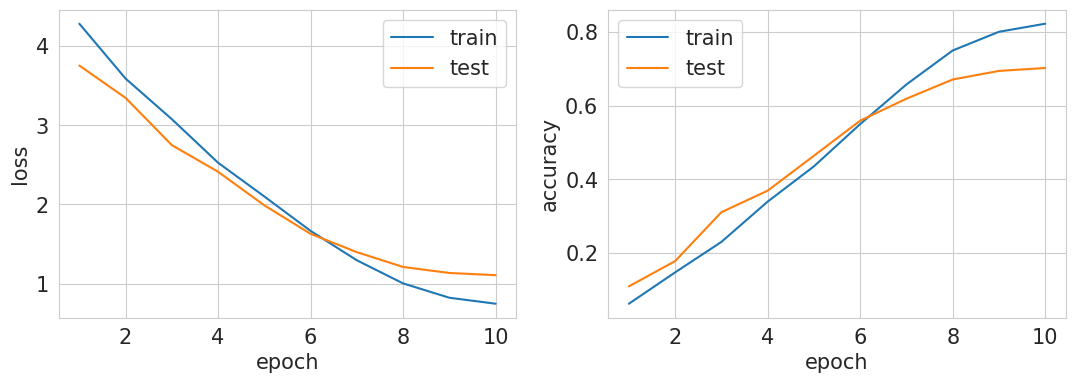

In [ ]:
train( )


In [ ]:
model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/vlad/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13.6M/13.6M [00:12<00:00, 1.17MB/s]


In [ ]:
num_epochs = 10
model.classifier[1] = torch.nn.Linear(1280, len(train_dataset.classes))
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)


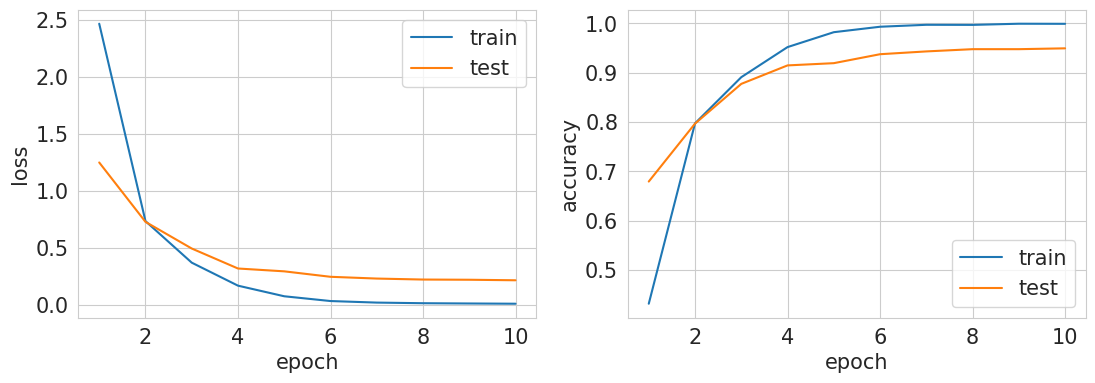

In [ ]:
train()